In [96]:
import os
import joblib
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, r_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [97]:
data = pd.read_csv('../data/processed/data.csv')
models = ['Linear Regression', 'Support Vector Machine', 'Random Forest', 'Gradient Boosting', 'Neural Network (MLP)']

### Exploratory Data Analysis

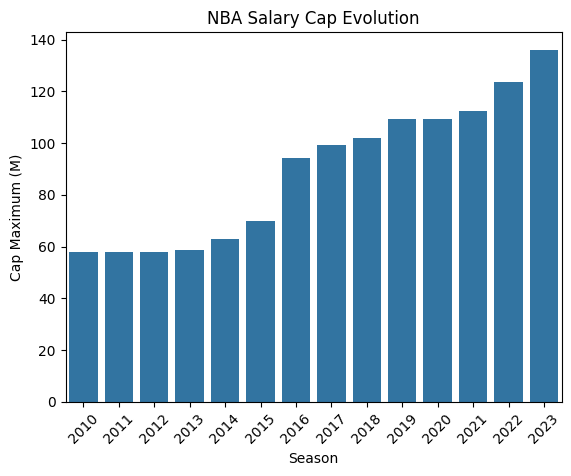

In [98]:
plt.xticks(rotation=45)
plt.ylabel('Cap Maximum (M)');
evol = sns.barplot(data=data,x='Season',y='Cap Maximum').set(title='NBA Salary Cap Evolution')

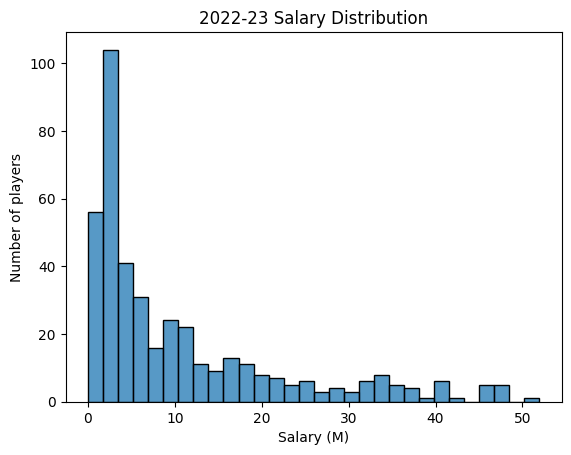

In [99]:
# 2023 Salary distribution
plt.xlabel('Salary (M)')
plt.ylabel('Number of players')
sns.histplot(data=data[data['Season'] == 2023],x='Salary',bins=30).set(title='2022-23 Salary Distribution');

### ML Models

In [101]:
# Function for metrics
def func_metrics(y_test, y_pred, metrics, modelo):
    
    rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)),3) # RMSE
    r2 = round(r2_score(y_test, y_pred),3) # R²
    
    dict_met = {'Model': [modelo],
                'RMSE': [rmse],
                'R²': [r2]}
    
    metric = pd.DataFrame(data=dict_met)
    metrics = pd.concat([metrics,metric])
    
    return metrics

In [102]:
def func_scaler(X_train, X_test):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Store the scaler
    scaler_file = '../models/scaler.sav'
    joblib.dump(scaler, scaler_file)
    
    return X_train, X_test

In [103]:
def split_data(data):
    X = data.drop(columns=['Salary','Player','Season'])
    y = data['Salary']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [104]:
X_train, X_test, y_train, y_test = split_data(data)
scaled_X_train, scaled_X_test = func_scaler(X_train, X_test)

In [110]:
def train_models(scaled_X_train, scaled_X_test, y_train, y_test, models):
    metrics = pd.DataFrame()
    best_params = []

    for model_label in models:
        # Creating instance for each model
        if model_label=='Support Vector Machine':
            param_grid = {'C': [0.001,0.01,0.1,0.5,1,2,5],
                         'kernel': ['linear','rbf','poly'],
                         'gamma': ['scale','auto'],
                         'degree': [2,3,4],
                         'epsilon': [0.1,0.5,1]}
            svr_model = SVR()
            grid = GridSearchCV(svr_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = SVR(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif model_label=='Random Forest':
            param_grid = {'n_estimators': [15,25,50,64,100,200],
                         'max_features': [2,3,5],
                         'bootstrap': [True,False],
                         'oob_score': [True]}
            rfc = RandomForestRegressor()
            grid = GridSearchCV(rfc, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = RandomForestRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif model_label=='Gradient Boosting':
            param_grid = {'n_estimators': [10,25,50],
                         'learning_rate': [0.01,0.05,0.1,0.5],
                         'max_depth': [3,4,5]}
            gb_model = GradientBoostingRegressor()
            grid = GridSearchCV(gb_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = GradientBoostingRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif model_label=='Neural Network (MLP)':
            param_grid = {'hidden_layer_sizes': [(100,),(200,),(300,)],
                         'activation': ['identity','relu'],
                         'solver': ['lbfgs','sgd','adam'],
                         'alpha': [0.0001,0.001,0.01, 0.1],
                         'max_iter': [500],
                         'learning_rate': ['constant','invscaling','adaptive']}
            mlp_model = MLPRegressor()
            grid = GridSearchCV(mlp_model, param_grid)
            grid.fit(scaled_X_train, y_train)
            model = MLPRegressor(**grid.best_params_)
            best_params.append(grid.best_params_)

        elif model_label=='Linear Regression':
            model = LinearRegression()
            best_params.append(None)

        model.fit(scaled_X_train, y_train)
        
        # Save the model
        joblib.dump(model, f'../models/{model_label}.sav')
        print(f'{model_label} trained and saved')
        
        y_pred = model.predict(scaled_X_test)
        metrics = func_metrics(y_test, y_pred, metrics, model)


In [ ]:
models = ['Random Forest', 'Neural Network (MLP)']
metrics, best_params = train_models(scaled_X_train, scaled_X_test, y_train, y_test, models)
metrics